**Phase 1: Data Preprocessing**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Food_Delivery_Time_Prediction.csv to Food_Delivery_Time_Prediction.csv


 Step 1: Data Import and Cleaning

Load the dataset (Food_Delivery_Time_Prediction.csv) **&** Handle missing values through imputation

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from math import radians, sin, cos, sqrt, atan2

# Load dataset
df = pd.read_csv('/content/Food_Delivery_Time_Prediction.csv')

# Display basic info
print("Initial Data Summary:")
print(df.info())


# Handle missing values

# Fill missing numeric values with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=[object]).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

Initial Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost   

Encode categorical features (e.g., weather, traffic, and vehicle type) using LabelEncoder  **&** Normalize continuous features such as distance and delivery time

Step 2: Feature Engineering:

Calculate the geographic distance between the customer and restaurant using latitude and longitude (Haversine formula)

In [ ]:
# Feature Engineering

# Helper function to calculate distance using the Haversine formula
def haversine(coord1, coord2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1 = map(radians, coord1)
    lat2, lon2 = map(radians, coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

# Parse coordinates and calculate geographic distance
# Add a check to see if the column exists before applying eval
if 'Customer_Location' in df.columns and 'Restaurant_Location' in df.columns:
    df['Customer_Location'] = df['Customer_Location'].apply(eval)
    df['Restaurant_Location'] = df['Restaurant_Location'].apply(eval)
    df['Geo_Distance'] = df.apply(lambda row: haversine(row['Customer_Location'], row['Restaurant_Location']), axis=1)

    # Drop original location columns
    df.drop(['Customer_Location', 'Restaurant_Location'], axis=1, inplace=True)
else:
    print("Error: 'Customer_Location' or 'Restaurant_Location' column not found in the DataFrame.")
    # You might want to add additional error handling here, like exiting or skipping

# Encode categorical features

label_enc = LabelEncoder()
# Add a check to see if columns exist before trying to encode
cols_to_encode = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']
for col in cols_to_encode:
    if col in df.columns:
        df[col] = label_enc.fit_transform(df[col])
    else:
        print(f"Warning: Column '{col}' not found for encoding.")


Error: 'Customer_Location' or 'Restaurant_Location' column not found in the DataFrame.


Create binary categories based on delivery time (e.g., 1 for delayed and 0 for fast)

In [ ]:
# Create binary target variable

# Threshold for "Delayed" can be the median delivery time
threshold = df['Delivery_Time'].median()
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > threshold else 0)


# Normalize continuous features

scaler = MinMaxScaler()
to_normalize = ['Geo_Distance', 'Distance', 'Delivery_Time', 'Order_Cost', 'Tip_Amount']
df[to_normalize] = scaler.fit_transform(df[to_normalize])


# Final feature set

X = df.drop(['Order_ID', 'Delivery_Status'], axis=1)
y = df['Delivery_Status']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preview final data
print("\nProcessed Features Sample:")
print(X_train.head())




Processed Features Sample:
     Distance  Weather_Conditions  Traffic_Conditions  \
79   0.973749                   2                   0   
197  0.824036                   2                   0   
38   0.175144                   3                   1   
24   0.432322                   3                   2   
122  0.373257                   3                   2   

     Delivery_Person_Experience  Order_Priority  Order_Time  Vehicle_Type  \
79                            7               0           0             0   
197                           4               2           0             1   
38                            9               2           0             2   
24                            5               2           1             1   
122                           9               0           3             0   

     Restaurant_Rating  Customer_Rating  Delivery_Time  Order_Cost  \
79                 4.6              2.8       0.352355    0.484134   
197                2.9    

**Phase 2: Classification using Naive Bayes, K-Nearest Neighbors, and Decision Tree**

Step 3: Naive Bayes Classifie

Apply the Gaussian Naive Bayes classifier, which is suitable for continuous features, to predict the binary class of delivery status (fast or delayed)  **&**  Evaluation Metrics: Accuracy, Confusion Matrix, Precision, Recall, F1-score.

In [ ]:
# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Dictionary to store results
results = {}


#Naive Bayes

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

# Save to results
results['Naive Bayes'] = {
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'Confusion Matrix': confusion_matrix(y_test, y_pred_nb),
    'Classification Report': classification_report(y_test, y_pred_nb, output_dict=True)
}

Naive Bayes Results:
Accuracy: 1.0
Confusion Matrix:
 [[19  0]
 [ 0 21]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



Step 4: K-Nearest Neighbors (KNN)

In [ ]:
# 2. K-Nearest Neighbors

# Tune K from 1 to 20
knn_params = {'n_neighbors': list(range(1, 21))}
knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train, y_train)

# Best K
best_knn = knn_grid.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("\nKNN Results (Best K =", knn_grid.best_params_['n_neighbors'], "):")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

# Save to results
results['KNN'] = {
    'Best K': knn_grid.best_params_['n_neighbors'],
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Confusion Matrix': confusion_matrix(y_test, y_pred_knn),
    'Classification Report': classification_report(y_test, y_pred_knn, output_dict=True)
}


KNN Results (Best K = 2 ):
Accuracy: 0.45
Confusion Matrix:
 [[14  5]
 [17  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.74      0.56        19
           1       0.44      0.19      0.27        21

    accuracy                           0.45        40
   macro avg       0.45      0.46      0.41        40
weighted avg       0.45      0.45      0.41        40



Step 5: Decision Tree

In [ ]:
#Decision Tree

# Tune max_depth and min_samples_split
dt_params = {
    'max_depth': list(range(3, 11)),
    'min_samples_split': [2, 5, 10]
}
dt_model = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)

# Best model
best_dt = dt_grid.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("\nDecision Tree Results (Best Params):", dt_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

# Save to results
results['Decision Tree'] = {
    'Best Params': dt_grid.best_params_,
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Confusion Matrix': confusion_matrix(y_test, y_pred_dt),
    'Classification Report': classification_report(y_test, y_pred_dt, output_dict=True)
}



Decision Tree Results (Best Params): {'max_depth': 3, 'min_samples_split': 2}
Accuracy: 0.975
Confusion Matrix:
 [[19  0]
 [ 1 20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.95      0.98        21

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



**Phase 3: Reporting and Insights**

In [30]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

# Load the dataset
df = pd.read_csv('/content/Food_Delivery_Time_Prediction.csv')  # Adjust path if needed

# Drop irrelevant columns
df.drop(columns=['Order_ID'], inplace=True)

# Fill missing values using mode for simplicity
df.fillna(df.mode().iloc[0], inplace=True)

# Label encode all categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Create binary target: 1 = Delayed, 0 = Fast (based on median delivery time)
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > df['Delivery_Time'].median() else 0)

# Define features (X) and target (y)
X = df.drop(columns=['Delivery_Status', 'Delivery_Time'])
y = df['Delivery_Status']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [33]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
y_score_nb = nb_model.predict_proba(X_test)[:, 1]

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_score_knn = knn_model.predict_proba(X_test)[:, 1]

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=6, min_samples_split=5, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_score_dt = dt_model.predict_proba(X_test)[:, 1]

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model("Naive Bayes", y_test, y_pred_nb)
evaluate_model("KNN", y_test, y_pred_knn)
evaluate_model("Decision Tree", y_test, y_pred_dt)




Naive Bayes Results:
Accuracy: 0.525
Confusion Matrix:
 [[10  9]
 [10 11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.53      0.51        19
           1       0.55      0.52      0.54        21

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.53        40


KNN Results:
Accuracy: 0.5
Confusion Matrix:
 [[11  8]
 [12  9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.58      0.52        19
           1       0.53      0.43      0.47        21

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.50        40
weighted avg       0.51      0.50      0.50        40


Decision Tree Results:
Accuracy: 0.4
Confusion Matrix:
 [[ 9 10]
 [14  7]]
Classification Report:
               precision    recall  f1-score   support

 

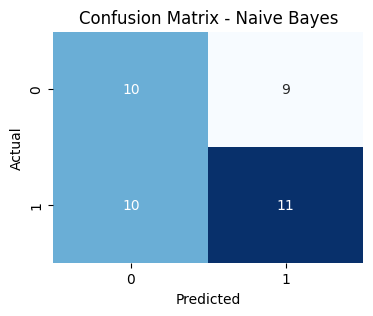

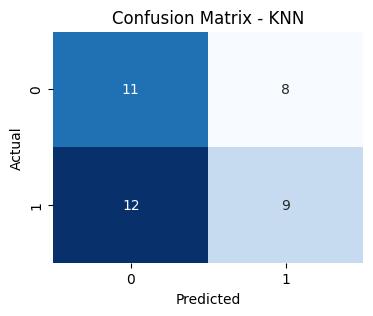

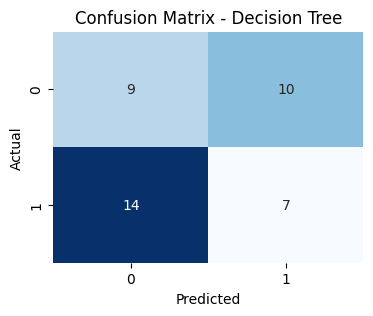

In [34]:
#Confusion Matrix Plots
def plot_conf_matrix(cm, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_conf_matrix(confusion_matrix(y_test, y_pred_nb), "Naive Bayes")
plot_conf_matrix(confusion_matrix(y_test, y_pred_knn), "KNN")
plot_conf_matrix(confusion_matrix(y_test, y_pred_dt), "Decision Tree")



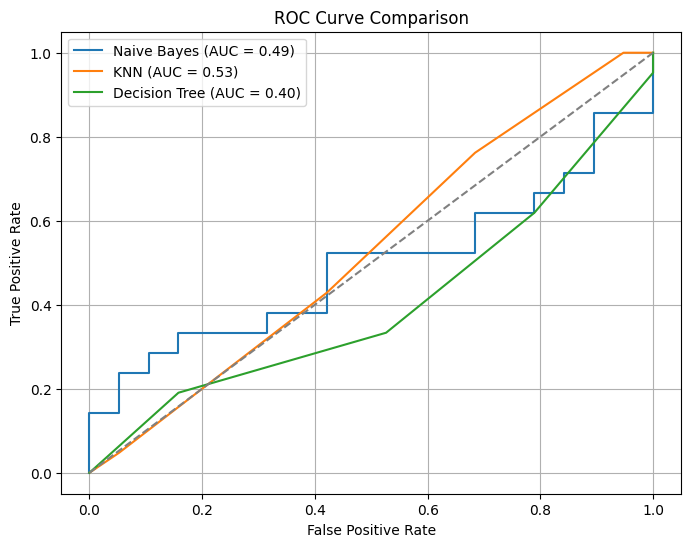

In [35]:
#ROC Curve Plot
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_score_nb)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_score_dt)

auc_nb = auc(fpr_nb, tpr_nb)
auc_knn = auc(fpr_knn, tpr_knn)
auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_nb:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_knn:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()